In [ ]:
import kagglehub

# Download latest version
# path = kagglehub.dataset_download("mexwell/tea-sickness-dataset")

print("Path to dataset files:", path)

100%|██████████| 740M/740M [00:12<00:00, 61.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mexwell/tea-sickness-dataset/versions/1


In [2]:
import os
import numpy as np
import tensorflow as tf
import mlflow
import mlflow.tensorflow
import dagshub

from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ==========================================
# 1. CONNECT TO DAGSHUB (The Permanent Link)
# ==========================================

# CHANGE THESE TO YOUR DETAILS!
REPO_OWNER = 'amarasinghelra'
REPO_NAME = 'TeaLeaf-Lens2'

print(f"Connecting to DagsHub: {REPO_OWNER}/{REPO_NAME}...")
dagshub.init(repo_owner=REPO_OWNER, repo_name=REPO_NAME, mlflow=True)
print("Connection Successful! MLflow is ready.")

# ==========================================
# 2. HYPERPARAMETERS
# ==========================================
EXP_NAME = "TeaLeaf_Lens_Optimization"
RUN_NAME = "MobileNetV3_DagsHub_Run"

PARAMS = {
    "EPOCHS": 10,
    "BATCH_SIZE": 32,
    "LEARNING_RATE": 0.01,
    "DROPOUT_RATE": 0.3,
    "IMG_SIZE": (224, 224)
}

# ==========================================
# 3. MLFLOW SETUP (The "Best of Both Worlds" Approach)
# ==========================================
mlflow.set_experiment(EXP_NAME)

# STRATEGY PART 1: Use Autolog for the standard training stats
mlflow.tensorflow.autolog()

print(f"Starting Run: {RUN_NAME}")

with mlflow.start_run(run_name=RUN_NAME):
    # Log our config
    mlflow.log_params(PARAMS)

    # --- Data Pipeline ---
    # Use the local dataset folder in the workspace
    final_data_dir = 'tea-sickness-dataset'
    
    if not os.path.exists(final_data_dir):
        raise FileNotFoundError(f"Dataset directory not found: {final_data_dir}")
    
    print(f"Using dataset from: {final_data_dir}")

    train_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
        rotation_range=30, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2,
        horizontal_flip=True, validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        final_data_dir, target_size=PARAMS["IMG_SIZE"], batch_size=PARAMS["BATCH_SIZE"],
        class_mode='categorical', subset='training'
    )
    val_generator = train_datagen.flow_from_directory(
        final_data_dir, target_size=PARAMS["IMG_SIZE"], batch_size=PARAMS["BATCH_SIZE"],
        class_mode='categorical', subset='validation'
    )

    # --- Model Build ---
    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(PARAMS["DROPOUT_RATE"])(x)
    predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=PARAMS["LEARNING_RATE"]),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    # --- Training (Autolog captures this automatically!) ---
    history = model.fit(train_generator, epochs=PARAMS["EPOCHS"], validation_data=val_generator)

    # --- Post-Processing: Quantization ---
    print("Quantizing model...")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()

    # STRATEGY PART 2: Manual Logging for the "Interview Metric"
    tflite_size_mb = len(tflite_model) / (1024 * 1024)
    final_val_acc = history.history['val_accuracy'][-1]

    print(f"Logging custom metrics to DagsHub...")
    mlflow.log_metric("tflite_size_mb", tflite_size_mb)
    mlflow.log_metric("final_val_acc", final_val_acc)

    # Optional: You can even save the TFLite file to DagsHub
    with open("tealeaf.tflite", "wb") as f:
        f.write(tflite_model)
    mlflow.log_artifact("tealeaf.tflite")

    print("\n" + "="*40)
    print(f"Success! Check your results at: https://dagshub.com/{REPO_OWNER}/{REPO_NAME}")
    print(f"Final TFLite Size: {tflite_size_mb:.2f} MB")
    print("="*40)


Connecting to DagsHub: amarasinghelra/TeaLeaf-Lens2...


Initialized MLflow to track repo "amarasinghelra/TeaLeaf-Lens2"

Repository amarasinghelra/TeaLeaf-Lens2 initialized!

Connection Successful! MLflow is ready.


2026/01/01 09:46:33 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.12.1 <= tensorflow <= 2.19.0, but the installed version is 2.20.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.


Starting Run: MobileNetV3_DagsHub_Run
Using dataset from: tea-sickness-dataset
Found 711 images belonging to 8 classes.
Found 174 images belonging to 8 classes.
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 6s 1us/step


2026/01/01 09:46:44 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2026/01/01 09:46:44 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
c:\Users\ASUS\miniconda\envs\tea\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3597 - loss: 1.8646

c:\Users\ASUS\miniconda\envs\tea\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.3662 - loss: 1.8429 - val_accuracy: 0.6149 - val_loss: 0.9667
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7295 - loss: 0.7102

23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.7297 - loss: 0.7099 - val_accuracy: 0.6552 - val_loss: 0.9051
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8005 - loss: 0.5919

23/23 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.8004 - loss: 0.5912 - val_accuracy: 0.7414 - val_loss: 0.6787
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8141 - loss: 0.4692 - val_accuracy: 0.6609 - val_loss: 0.8507
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8061 - loss: 0.5117 - val_accuracy: 0.7471 - val_loss: 0.7305
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8555 - loss: 0.4003 - val_accuracy: 0.7471 - val_loss: 0.6863
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8107 - loss: 0.4826 - val_accuracy: 0.7126 - val_loss: 0.7751
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8378 - loss: 0.4189

23/23 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8381 - loss: 0.4182 - val_accuracy: 0.7414 - val_loss: 0.6692
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8581 - loss: 0.3603 - val_accuracy: 0.7529 - val_loss: 0.7065
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8303 - loss: 0.4231 - val_accuracy: 0.7414 - val_loss: 0.8645


2026/01/01 09:54:38 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2026/01/01 09:54:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/01 09:54:42 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2026/01/01 09:54:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Quantizing model...
INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpaocdv06j\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpaocdv06j\assets


Saved artifact at 'C:\Users\ASUS\AppData\Local\Temp\tmpaocdv06j'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  3198412003984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3198412386896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3198412387424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3198412386368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3198412386544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3198412404688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3198412416800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3198412417856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3198412415392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3198412416624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  319841

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


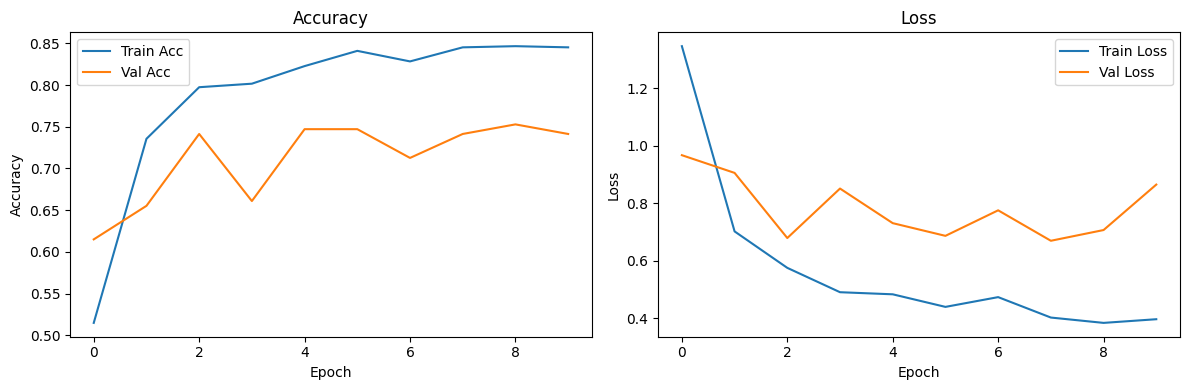

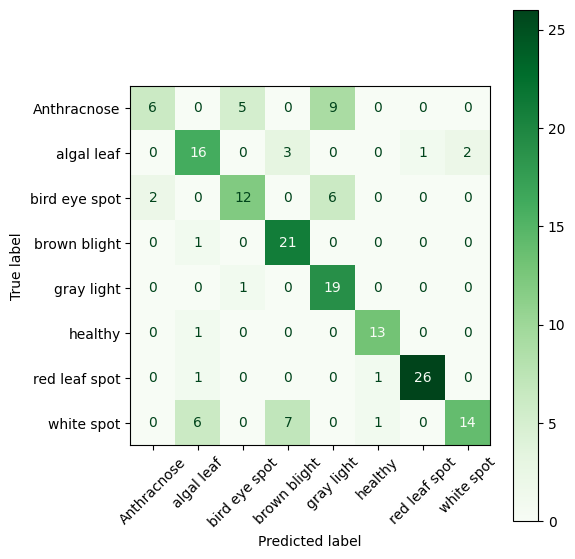

In [8]:
# Combined accuracy and loss plots and save the figure
import matplotlib.pyplot as plt

# Create a wide figure with two subplots: left = accuracy, right = loss
plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history.history["accuracy"], label="Train Acc")
ax1.plot(history.history["val_accuracy"], label="Val Acc")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy")
ax1.legend()

ax2 = plt.subplot(1, 2, 2)
ax2.plot(history.history["loss"], label="Train Loss")
ax2.plot(history.history["val_loss"], label="Val Loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("Loss")
ax2.legend()

plt.tight_layout()
plt.savefig("results/train_val_metrics.png", dpi=150)

# Compute confusion matrix on the validation set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Collect predictions from the validation generator until we've covered all validation samples
y_true, y_pred = [], []
for batch_x, batch_y in val_generator:
    # Predict on the current batch
    preds = model.predict(batch_x)
    # Convert one-hot labels and predictions to class indices
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    # Stop once we've gathered predictions for the whole validation set
    if len(y_true) >= val_generator.samples:
        break

# Build and save confusion matrix visualization
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=list(val_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Greens", ax=ax, xticks_rotation=45)
plt.tight_layout()
plt.savefig("results/confusion_matrix.png", dpi=150)
